# Riverstone NLP Test

 This test is designed to ascertain a candidate’s competency in Python to manipulate data, processes and  analyze text, and produce a simple R-Shiny application to explore results. Ability to communicate  through visualized output is important as well. Lastly, candidates must be able to explain the rationale for  processing and modeling decisions both through thorough documentation and discussion. 

In [1]:
# Title: RiverStone NLP Test
# Author: Tadhg Lynch
# Date: 2023-4-14

## Data 
Download the csv here https://www.kaggle.com/rootuser/worldnews-on-reddit 

From Kaggle:

Reddit is a social network which divide topics into so called 'subreddits'. <br>
In subreddit 'worldnews', news of the whole world are published. The dataset contains following columns: <br>
- time_created - a Unix timestamp of the submission creation date <br>
- date_created - creation time in %Y-%m-%d <br>
- up_votes - how often the submission was upvoted <br>
- down_votes - how often the submission was downvoted <br>
- title - the title of the submission <br>
- over_18 - if the submission is for mature persons <br>
- author - the reddit username of the author <br>
- subreddit - this is always 'worldnews'

## Requirements
To set up venv for dependency control head over to terminal and type: <br>
1. Python3 -m venv venv
2. venv/Scripts/Activate.ps1
3. pip install -r requirement.txt

Should be all set with correct package versions then!

In [2]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import requests
import csv
import openai
# making a pop up window to ask for your openai api key
import tkinter as tk
from tkinter import simpledialog
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [3]:
#import data
df = pd.read_csv("data/reddit_worldnews_start_to_2016-11-22.csv")

df.info() # non-nulls across the board, nice

# I like to see the data
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509236 entries, 0 to 509235
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   time_created  509236 non-null  int64 
 1   date_created  509236 non-null  object
 2   up_votes      509236 non-null  int64 
 3   down_votes    509236 non-null  int64 
 4   title         509236 non-null  object
 5   over_18       509236 non-null  bool  
 6   author        509236 non-null  object
 7   subreddit     509236 non-null  object
dtypes: bool(1), int64(3), object(4)
memory usage: 27.7+ MB


,time_created,date_created,up_votes,down_votes,title,over_18,author,subreddit
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


## Request 1
### Description: Build and graph a seasonal index of average upvotes by post at the Monthly, Day of Week, and Hour of  Day levels. 

In [4]:
# converting unix timestamp as will be needed for hourly
df['time_created'] = pd.to_datetime(df['time_created'], unit='s')

# check that new time_created matches date_created
matching = df['time_created'].dt.date == pd.to_datetime(df['date_created']).dt.date

# show df columns where matching is false
df[matching == False]

# There is a singular mismatched case that has been caused by a post being created at exactly midnight, so will be sticking with the converted unix timestamp
# despite not being shown, it has time of 00:00:00, so will be fine for hourly

,time_created,date_created,up_votes,down_votes,title,over_18,author,subreddit
343260,2015-02-10,2015-02-09,7,0,Christians in India want their own Christian c...,False,InternetOfficer,worldnews


In [5]:
# Function to graph seasonal index
def graph_seasonal_index(df, level):
    # group by level
    df_grouped = df.groupby(level)['up_votes'].mean()
    # graph seasonal index
    df_grouped.plot()

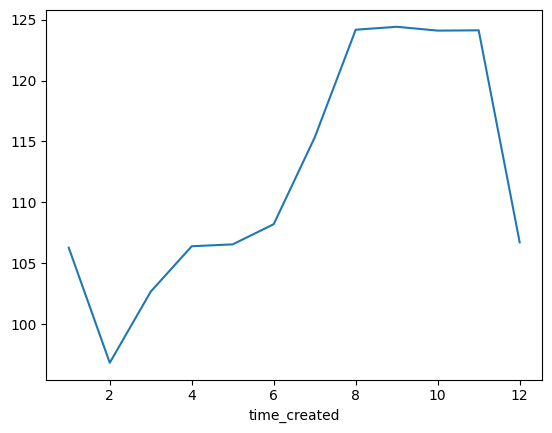

In [6]:
graph_seasonal_index(df, df['time_created'].dt.month)

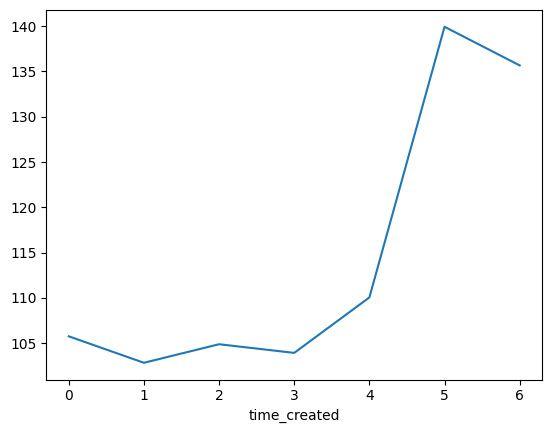

In [7]:
graph_seasonal_index(df, df['time_created'].dt.dayofweek)

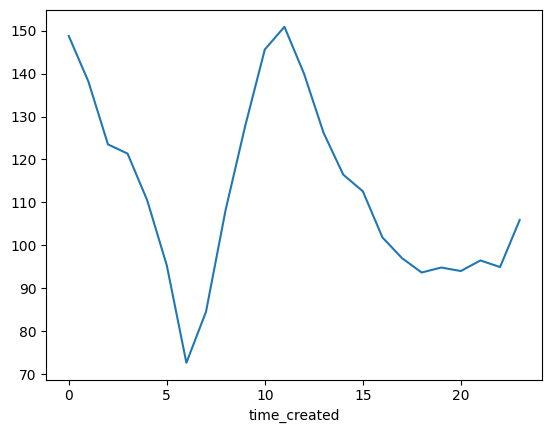

In [8]:
graph_seasonal_index(df, df['time_created'].dt.hour)

## Request 2
### Clean, scrub, and prepare post titles using standard NLP techniques. 

The Subreddit posted rules: <br>
1. No US Internal News or Politics <br>
2. No Editorialized or Misleading Titles <br>
3. No Feature stories <br>
4. No Editorials, Opinion or Analysis Pieces <br>
5. No Articles In Languages Other Than English <br>
6. No Images, Videos or Audio Clips <br>
7. No Bigotry or Other Offensive Content <br>
8. No Personal Attacks On Other Users <br>
9. No Memes, Gifs, unlabeled NSFW images <br>
10. No Old News Articles (≥ 1 Week old) <br>

Main NLP Takeaways: <br>
- no sentiment or sarcasm <br>
- no other languages  <br>
- unlikely to have poor grammar or misspellings (inferred by presence of reddit moderators) <br>
- no emojis <br>

NLP ideas: <br>
- Lots on Russia invasion of Ukraine, look out of more sparse references (e.g. Crimea, Moscow, Putin, etc.)... nevermind, dataset only goes up to 2016-11-22

In [9]:
# function to clean, scrub, and prepare post title using standard NLP techniques
def clean_post_title(post_title):
    # convert to lowercase
    post_title = post_title.lower()
    # remove single characters
    post_title = ' '.join([word for word in post_title.split() if len(word) > 1])
    # remove stop words
    #nltk.download('stopwords')
    stop_words = nltk.corpus.stopwords.words('english')
    post_title = ' '.join([word for word in post_title.split() if word not in stop_words])
    # remove punctuation
    post_title = ' '.join([word for word in post_title.split() if word.isalpha()])
    # remove extra whitespace
    post_title = ' '.join(post_title.split())

    # other possible cleaning techniques:
    # remove numbers: no because they may be important
    # merging synonyms and aliases: OpenAI's models will handle this

    return post_title


clean_titles = df['title'].apply(clean_post_title)

# would apply more cleaning techniques, but OpenAI's models take care of this for us; in fact think what has been removed already may not be optimal as the model is designed to handle natural writing, so jumping to Request 3 and seeing how it goes before returning to this.

## Request 3
cluster post titles and identify the top 20 clusters by frequency. Use of Chat-GPT AI is encouraged. 

#### Using OpenAI's API: https://platform.openai.com/docs/introduction/overview
##### Model Options:
![Model Options](.\images\openai-model-options.png)

#### Ada costs $0.0004/1000 tokens, 1 token is roughly 4 characters, so let's work out how much this will end up costing

In [10]:
titles = df['title'].tolist()

# get total number of characters
total_chars = 0
for title in titles:
    total_chars += len(title)

total_tokens = total_chars / 4
total_cost = total_tokens * 0.0004 / 1000
print("total_titles", len(titles))
print("total_chars:", total_chars)
print("total_tokens:", total_tokens)
print("total_cost:", total_cost)

total_titles 509236
total_chars: 45549165
total_tokens: 11387291.25
total_cost: 4.5549165


### Embeddings

In [38]:
# a pop-up window will appear asking for the API key
root = tk.Tk() # this is the pop up window
root.withdraw() # this hides the pop up window

# the input dialog
USER_INP = simpledialog.askstring(title="OpenAI API Key",
                                    prompt="What is your OpenAI API Key?")
openai.api_key = USER_INP

# Set the API endpoint and model name
endpoint = "https://api.openai.com/v1/embeddings"
model_name = "text-embedding-ada-002"

# Define your list of input strings
input_strings = titles

# Split input strings into batches
batch_size = 10000
input_string_batches = [input_strings[i:i+batch_size] for i in range(0, len(input_strings), batch_size)]

# Define the headers and data for the API request
headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {openai.api_key}"
}

# Create a CSV file to write embeddings
with open("embeddings.csv", "w", newline="", encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)

    # Write header to the CSV file
    writer.writerow(["Input_String", "Embedding"])

    # Loop through input string batches
    for batch in input_string_batches:
        data = {
            "input": batch,
            "model": model_name
        }

        # Send the API request
        response = requests.post(endpoint, headers=headers, json=data)

        # Parse the response and extract the embeddings
        if response.status_code == 200:
            embeddings = response.json()["data"]

            # Write embeddings to the CSV file
            for i in range(len(batch)):
                writer.writerow([batch[i], embeddings[i]])
        else:
            print("Failed to get embeddings. Response code:", response.status_code)

# delete stored openai api key
del openai.api_key
del USER_INP



#### Checkpoint

In [9]:
# load data
datafile_path = "./data/embeddings.csv"
df = pd.read_csv(datafile_path)

# extract embedding from string
df["Embedding"] = [i['embedding'] for i in df.Embedding.apply(eval)]

matrix = np.vstack(df.Embedding.values)
matrix.shape

# save matrix as this takes about 15 minutes to run
np.save("./data/embeddings.npy", matrix)

In [3]:
# checkpoint
# load data
matrix = np.load("./data/embeddings.npy")
matrix.shape

(509236, 1536)

### Reducing feature space down using SVD

components: 1
components: 101
components: 201
components: 301
components: 401
components: 501


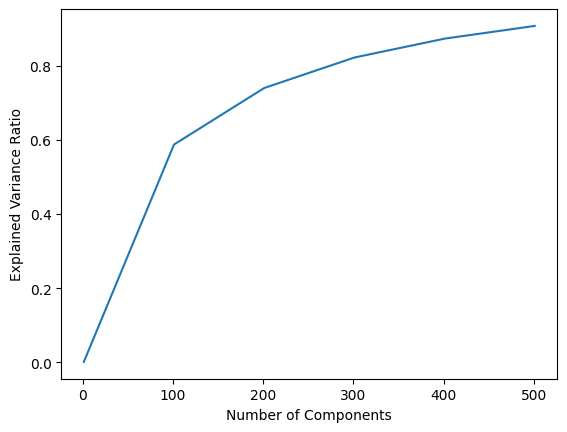

In [4]:
# 1536 dimensions is a lot, so let's try to reduce this using SVD
# sample 50,000 rows to speed up the process to find optimal number of components
sample = np.random.choice(matrix.shape[0], 50000, replace=False)

components_list = [i for i in range(1, 600, 100)]
explained_variance_ratios = []
for components in components_list:
    print("components:", components)
    svd = TruncatedSVD(n_components=components)
    svd.fit(matrix[sample])
    explained_variance_ratios.append(svd.explained_variance_ratio_.sum())

# plot explained variance ratio
import matplotlib.pyplot as plt
plt.plot(components_list, explained_variance_ratios)
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratio")
plt.show()

100 components seems fine given how computationally intense later steps are going to be, but 200 likely best

In [7]:
# 100 components seems to be a good number

svd = TruncatedSVD(n_components=100)
svd.fit(matrix)
matrix_reduced = svd.transform(matrix)
matrix_reduced.shape

(509236, 100)

In [ ]:
# Deciding on number of clusters for k-means using mini-batch k-means
# Elbow method & silhouette score

# random sample
sample = np.random.choice(matrix_reduced.shape[0], 5000, replace=False)

# instead of random sample, take sequential sample as topics may be clustered together in time
sample = np.arange(0, 50000)

sum_of_squared_distances = []
silhouette_scores = []
K = range(200, 5000, 200)
for k in K:
    print(k)
    km = MiniBatchKMeans(n_clusters=k, batch_size = 128, n_init=1) #setting n_init to 1 to speed up
    km = km.fit(matrix_reduced)
    sum_of_squared_distances.append(km.inertia_)
    silhouette_scores.append(silhouette_score(matrix_reduced, km.labels_))
    
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.show()

In [11]:
# cluster with batch k-means and 100 cluster size
from sklearn.cluster import MiniBatchKMeans
km = MiniBatchKMeans(n_clusters=100, batch_size=64, n_init=10)
km.fit(matrix_reduced)

# chop to first 50,000 titles and append cluster labels
df["cluster"] = km.labels_

### t-sne visualization

In [14]:
# just use a random sample of 50000
sample = np.random.choice(matrix_reduced.shape[0], 50000, replace=False)

# perplexity set to sqert of number of samples just as a starting point, could tune in the future
tsne = TSNE(n_components=2, verbose=1, perplexity=np.sqrt(len(matrix_reduced)), n_iter=300)
tsne_results = tsne.fit_transform(matrix_reduced[sample])

[t-SNE] Computing 2141 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.003s...
[t-SNE] Computed neighbors for 50000 samples in 14.504s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for 

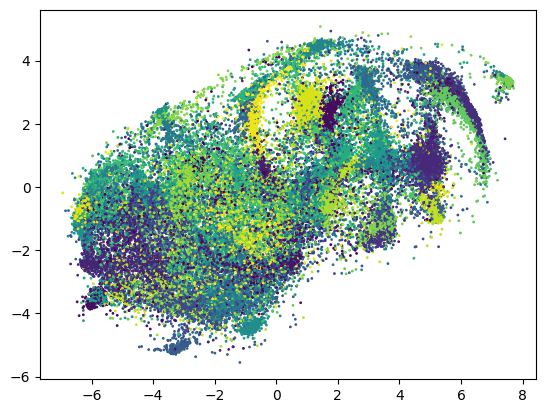

In [17]:
# scatter plot with cluster labels
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=df.cluster[sample], s=1)
# save out as 25000 with 12500 clusters
plt.savefig("./images/full-pass-100c-64b.png")
plt.show()

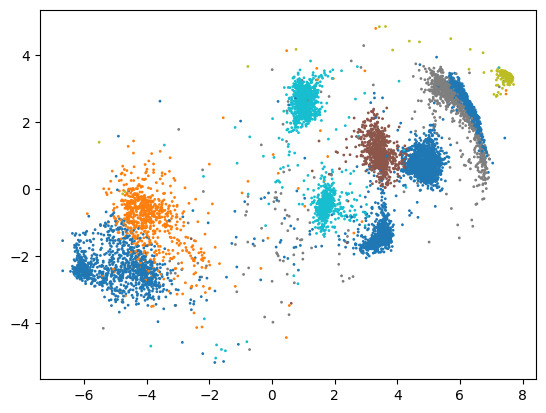

In [18]:
# let's visualize the same thing but with the top 10 topics

# get top 10 topics
top_10 = df.cluster.value_counts().head(10).index
top_10_tsne = tsne_results[df.cluster[sample].isin(top_10)]

# scatter plot
plt.scatter(top_10_tsne[:,0], top_10_tsne[:,1], c=df.cluster[sample][df.cluster[sample].isin(top_10)], s=1, cmap="tab10")

Fun Fact: COVID: ' All posts are about the coronavirus pandemic.'

In [19]:
#pop up window to get API key
root = tk.Tk() # this is the pop up window
root.withdraw() # this hides the pop up window

# the input dialog
USER_INP = simpledialog.askstring(title="OpenAI API Key",
                                    prompt="What is your OpenAI API Key?")
openai.api_key = USER_INP


# Reading reviews from the top 20 clusters by size
n_clusters = 20
top_clusters = df.cluster.value_counts().index[:n_clusters]

# number of reviews per cluster to use to generate a theme
rev_per_cluster = 20

#empty df to store cluster, 5 titles, and their theme
df_top_clusters = pd.DataFrame(columns=["cluster", "theme"])

print_examples = False
for i in range(n_clusters):
    reviews = "\n".join(
        df[df.cluster == top_clusters[i]].title.values[:rev_per_cluster]
    )
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=f'The following reddit posts all have a shared topic, what do they have in common?\n\nReddit titles:\n"""\n{reviews}\n"""\n\nTheme:',
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print("Cluster", top_clusters[i], "size:", df[df.cluster == top_clusters[i]].shape[0], "Theme:", response["choices"][0]["text"].replace("\n", ""))
    if print_examples:
        for j in range(5):
            print(df[df.cluster == top_clusters[i]].title.values[j])
        print("\n")

    # save out the top 3 clusters to df_top_clusters for app.py
    if i < 3:
        df_top_clusters = pd.concat(
            [df_top_clusters, pd.DataFrame(
                {
                    "cluster": [top_clusters[i]],
                    "theme": [response["choices"][0]["text"].replace("\n", "")]
                }
            )]
        )

# delete stored openai api key
del openai.api_key
del USER_INP

Cluster 11 size: 17959 Theme:  The Middle East, particularly Syria and Lebanon
Cluster 10 size: 11601 Theme:  Unusual News Stories
Cluster 79 size: 11476 Theme:  North Korea
Cluster 13 size: 9955 Theme:  Politics and current events in Ukraine and surrounding countries.
Cluster 75 size: 9705 Theme:  Politics in Russia
Cluster 15 size: 9249 Theme:  Israel and the Middle East
Cluster 54 size: 8511 Theme:  The War in Iraq
Cluster 86 size: 8345 Theme:  Protests and unrest in Egypt.
Cluster 93 size: 7854 Theme:  Pakistan
Cluster 26 size: 7645 Theme:  Financial/Tax Fraud/Evasion
Cluster 23 size: 7184 Theme:  UK News
Cluster 47 size: 7109 Theme:  Crimes and Controversies
Cluster 82 size: 7012 Theme:  UK Politics
Cluster 5 size: 6738 Theme:  Terrorism and Al-Qaeda
Cluster 67 size: 6698 Theme:  India
Cluster 61 size: 6631 Theme:  Middle East Politics
Cluster 33 size: 6560 Theme:  Iran and its nuclear ambitions/relations with the US and other countries.
Cluster 2 size: 6516 Theme:  Protests and D

#### merge and save out the top three clusters for use in app.py

In [20]:
# merge df_top_clusters with df on cluster
df_merged = df.merge(df_top_clusters, on="cluster", how="right")

# save out to csv
df_merged.to_csv("./data/df_top_three_clusters.csv", index=False)

### Test out some hierachical clustering later if you have time
https://petuum.medium.com/scalable-clustering-for-exploratory-data-analysis-60b27ea0fb06 <br>
Supposedly works better when there are clusters amongst noise which seems great for this context, but doesn't scale well without using some graphical methods

<bound method _AxesBase.set_ylabel of <Axes: >>

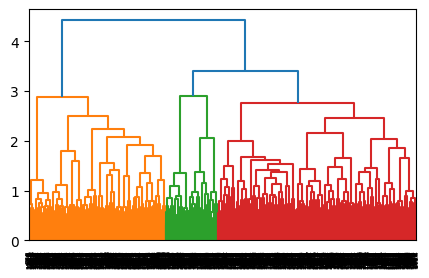

In [21]:
# now trying with agglomerative hierachical clustering using ward linkage
from scipy.cluster.hierarchy import dendrogram, linkage

sample = np.random.choice(matrix_reduced.shape[0], 2000, replace=False)
ac = linkage(matrix_reduced[sample], 'ward', optimal_ordering=True, )

# visualise on dendrogram
fig, ax = plt.subplots(figsize=(5, 3)) # set size
dn = dendrogram(ac, ax=ax)
ax.set_ylabel

## Request 4 
### Build a simple, local web app displaying an interactive vizualization of the top 3 clusters from Request 3. 

Run in command: <br>
python app.py

I'll be setting this up in a venv for dependencies when I get the chance

## Request 5
Build a model to predict the number of upvotes by post and show model diagnostics (if applicable) and  accuracy.


In [2]:
# packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [31]:
# creating df of month, year, day, hour, minute, and second from unix time_created
df["year"] = pd.to_datetime(df["time_created"], unit="s").dt.year
df["month"] = pd.to_datetime(df["time_created"], unit="s").dt.month
# name of day of week
df['day_of_week'] = pd.to_datetime(df["time_created"], unit="s").dt.day
df["hour_of_day"] = pd.to_datetime(df["time_created"], unit="s").dt.hour
# weeks since start of data
df["weeks_since_start"] = (pd.to_datetime(df["time_created"], unit="s") - pd.to_datetime(df["time_created"], unit="s").min()).dt.days // 7
# df["minute"] = pd.to_datetime(df["time_created"], unit="s").dt.minute
# df["second"] = pd.to_datetime(df["time_created"], unit="s").dt.second

# taking the log of the upvotes as posts grow exponentially with virality
# fixing for 0 upvotes
df["log_upvotes"] = np.log(df["up_votes"] + 1)

In [23]:
df.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,subreddit,cluster,year,month,day_of_week,hour_of_day,weeks_since_start,log_upvotes
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews,93,2008,1,Friday,3,0,1.386294
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews,46,2008,1,Friday,3,0,1.098612
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews,24,2008,1,Friday,3,0,1.386294
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews,9,2008,1,Friday,3,0,0.693147
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews,53,2008,1,Friday,15,0,1.609438


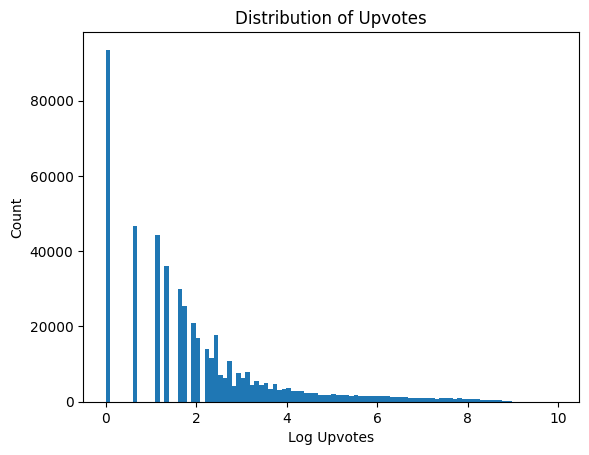

In [4]:
# select a random month from each year to plot all their upvote distributions on the same histogram to show constant distribution

# plot the distribution of log upvotes
plt.hist(df["log_upvotes"], bins=100)
plt.title("Distribution of Upvotes")
plt.xlabel("Log Upvotes")
plt.ylabel("Count")
plt.show()

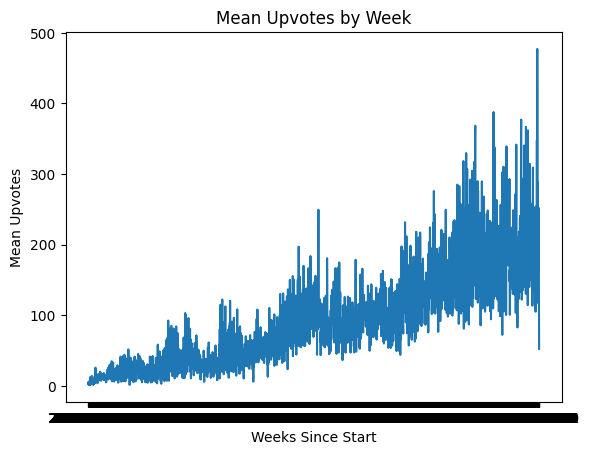

In [5]:
# plot the mean upvotes by weeks_since_start
plt.plot(df.groupby("date_created")["up_votes"].mean())
plt.title("Mean Upvotes by Week")
plt.xlabel("Weeks Since Start")
plt.ylabel("Mean Upvotes")
plt.show()

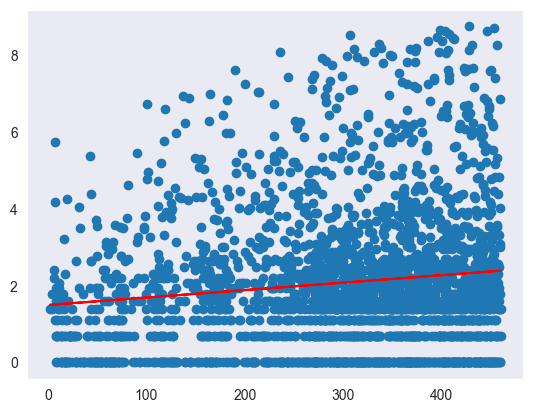

In [61]:
# base model
# just the upvotes trend over time

# fit linear model to months since start and log upvotes
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# fit linear model
model = LinearRegression()
model.fit(df[["weeks_since_start"]], df["log_upvotes"])

# plot model over a scatter of just 0.5% so you can actuall get an idea for distribution
df_sample = df.sample(frac=0.005)
plt.scatter(df_sample["weeks_since_start"], df_sample["log_upvotes"])
plt.plot(df_sample["weeks_since_start"], model.predict(df_sample[["weeks_since_start"]]), color="red")
plt.show()

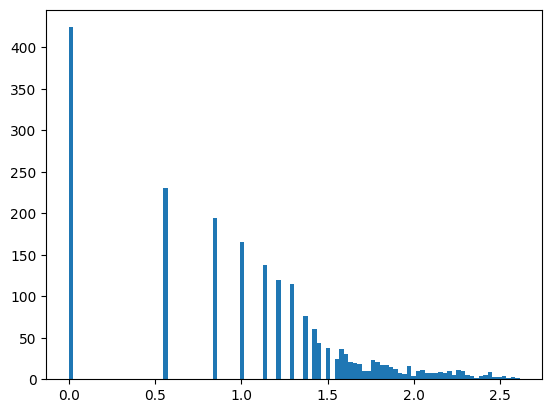

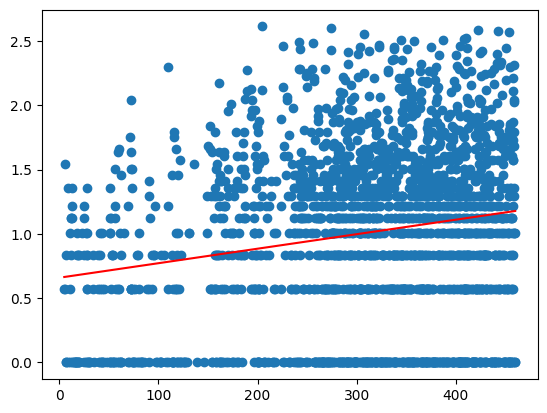

In [33]:
# let's try some box-cox
from scipy import stats

# box-cox transform
df["log_upvotes_boxcox"], _ = stats.boxcox(df_sample["log_upvotes"]+1)

# plot the distribution of log upvotes
plt.hist(df_sample["log_upvotes_boxcox"], bins=100)
plt.show()

# fit linear model
model = LinearRegression()
model.fit(df_sample[["weeks_since_start"]], df_sample["log_upvotes_boxcox"])

# plot model over a scatter of just 0.5% so you can actuall get an idea for distribution
plt.scatter(df_sample["weeks_since_start"], df_sample["log_upvotes_boxcox"])
plt.plot(df_sample["weeks_since_start"], model.predict(df_sample[["weeks_since_start"]]), color="red")
plt.show()

                 Generalized Linear Model Regression Results                  
Dep. Variable:               up_votes   No. Observations:                 2546
Model:                            GLM   Df Residuals:                     2544
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -7.2792e+05
Date:                Tue, 18 Apr 2023   Deviance:                   1.4470e+06
Time:                        22:58:45   Pearson chi2:                 5.50e+06
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.1248      0.00

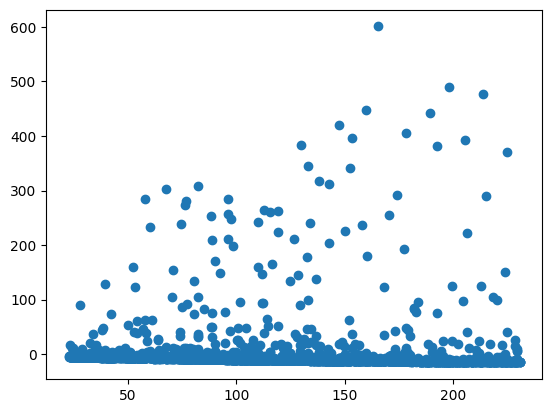

In [29]:
# not even box-cox can fix this, time to bring out the glm
# let's try a poisson regression
import statsmodels.api as sm
import statsmodels.formula.api as smf

# fit poisson regression
model = smf.glm(formula="votes ~ weeks_since_start", data=df_sample, family=sm.families.Poisson()).fit()
print(model.summary())

# plot residuals over predicted values
plt.scatter(model.predict(df_sample), model.resid_pearson)
plt.show()

                 Generalized Linear Model Regression Results                  
Dep. Variable:            log_upvotes   No. Observations:               504143
Model:                            GLM   Df Residuals:                   504141
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.3359e+05
Date:                Tue, 18 Apr 2023   Deviance:                   7.8068e+05
Time:                        23:18:07   Pearson chi2:                 7.39e+05
No. Iterations:                     5   Pseudo R-squ. (CS):            0.01657
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.4581      0.00

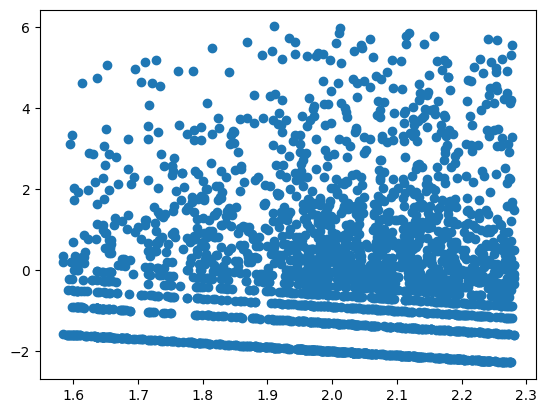

In [42]:
# need to remove some of these anomalies
# remove top 1% of upvotes
df_99 = df[df["up_votes"] < df["up_votes"].quantile(0.99)]

# fit poisson regression
model = smf.glm(formula="log_upvotes ~ weeks_since_start", data=df_99, family=sm.families.Poisson()).fit()
print(model.summary())

# plot 0.5% of residuals over predicted values
df_sample = df_99.sample(frac=0.005)
plt.scatter(model.predict(df_sample), df_sample["log_upvotes"] - model.predict(df_sample))
plt.show()

Okay now let's build ourselves a neural network predictor which takes into account the title embeddings

In [6]:
# reading in the embeddings
embeddings_path = "./data/embeddings.npy"
embeddings = np.load(embeddings_path)

# reduce dimensionality of embeddings using svd
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
matrix_reduced = svd.fit_transform(embeddings)

In [31]:
# revisit this when you've got the time to set up gpu drivers for tensorflow
# import tensorflow as tf
# tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [40]:
# model building

# x is the matrix of embeddings and the month, year, day, hour of the post (from unix time_created in df)
# y is the number of upvotes
# normalize matrix_reduced values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
normalize_matrix_reduced = scaler.fit_transform(matrix_reduced)

#normalize weeks_since_start
df["normalize_weeks_since_start"] = scaler.fit_transform(df[["weeks_since_start"]])

x = np.concatenate((normalize_matrix_reduced, df[["normalize_weeks_since_start"]].values), axis=1)

y = df["log_upvotes"].values

# split into train and test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# build model
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

model = Sequential()
model.add(Dense(128, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(32, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(16, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(8, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer="adam", loss="mean_squared_logarithmic_error")

# train model
model.fit(x=x_train, y=y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

# evaluate model
model.evaluate(x_test, y_test)

# save model
model.save("./models/upvotes_model.h5")

Epoch 1/10
12731/12731 [==============================] - 25s 2ms/step - loss: 0.3533 - val_loss: 0.3196
Epoch 2/10
12731/12731 [==============================] - 23s 2ms/step - loss: 0.3247 - val_loss: 0.3154
Epoch 3/10
12731/12731 [==============================] - 23s 2ms/step - loss: 0.3225 - val_loss: 0.3140
Epoch 4/10
12731/12731 [==============================] - 23s 2ms/step - loss: 0.3216 - val_loss: 0.3142
Epoch 5/10
12731/12731 [==============================] - 22s 2ms/step - loss: 0.3212 - val_loss: 0.3121
Epoch 6/10
12731/12731 [==============================] - 22s 2ms/step - loss: 0.3210 - val_loss: 0.3115
Epoch 7/10
12731/12731 [==============================] - 23s 2ms/step - loss: 0.3205 - val_loss: 0.3121
Epoch 8/10
12731/12731 [==============================] - 23s 2ms/step - loss: 0.3206 - val_loss: 0.3113
Epoch 9/10
12731/12731 [==============================] - 22s 2ms/step - loss: 0.3204 - val_loss: 0.3129
Epoch 10/10
3183/3183 [==============================] 

So the model is really struggling to identify any of the complexity of the posts, so for the sake of fun, let's overfit it to be sure that there is some separation

In [43]:
# x is the matrix of embeddings and the weeks_since_start of the post (from unix time_created in df)
# y is the number of upvotes
normalize_matrix = scaler.fit_transform(matrix)

x = np.concatenate((normalize_matrix, df[["weeks_since_start"]].values), axis=1)


y = df["log_upvotes"].values

# split into train and test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# build model
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(optimizer="adam", loss="mean_squared_logarithmic_error")

# train model
model.fit(x=x_train, y=y_train, batch_size=128, epochs=10)

# save model
model.save("./models/upvotes_model_overfit_no_val.h5")

313/313 [==============================] - 0s 658us/step


C:\Users\JCAT\AppData\Local\Temp\ipykernel_17204\1051253229.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_1000["predictions"] = model.predict(np.concatenate((matrix_reduced[-10000:], last_1000[["weeks_since_start"]].values), axis=1))


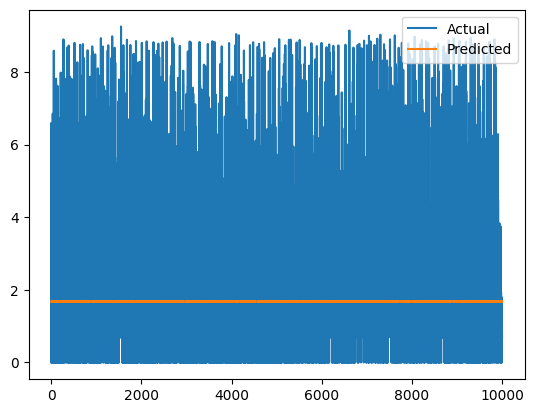

In [29]:
# get predictions for the last 1000 points of data
last_1000 = df.iloc[-10000:]
last_1000["predictions"] = model.predict(np.concatenate((matrix_reduced[-10000:], last_1000[["weeks_since_start"]].values), axis=1))

# plot actuals and predictions
plt.plot(np.arange(10000), last_1000["log_upvotes"], label="Actual")
plt.plot(np.arange(10000), last_1000["predictions"], label="Predicted")
plt.legend()
plt.show()